 **Basic Data Structures for our System**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import math
import time
from datetime import datetime, timedelta
from matplotlib.widgets import Slider
import matplotlib.colors as mcolors

class Waypoint:
    def __init__(self, x, y, z=0):
        self.x = x
        self.y = y
        self.z = z  # Including z for 3D support
    
    def __repr__(self):
        return f"Waypoint(x={self.x}, y={self.y}, z={self.z})"
        
class DroneFlightPlan:
    def __init__(self, drone_id, waypoints, start_time, end_time):
        self.drone_id = drone_id
        self.waypoints = waypoints  # List of Waypoint objects
        self.start_time = start_time
        self.end_time = end_time
        
    def __repr__(self):
        return f"DroneFlightPlan(id={self.drone_id}, waypoints={len(self.waypoints)}, time={self.start_time}-{self.end_time})"
        
class Conflict:
    def __init__(self, drone_id, location, time, distance):
        self.drone_id = drone_id
        self.location = location  # Waypoint object
        self.time = time
        self.distance = distance
        
    def __repr__(self):
        return f"Conflict(drone_id={self.drone_id}, location={self.location}, time={self.time}, distance={self.distance})"

class ConflictResult:
    def __init__(self, status, conflicts=None):
        self.status = status  # "clear" or "conflict detected"
        self.conflicts = conflicts or []  # List of Conflict objects
        
    def __repr__(self):
        return f"ConflictResult(status={self.status}, conflicts={len(self.conflicts)})"


**The core Deconfliction service that will check for conflicts**

In [2]:
class DeconflictionService:
    def __init__(self, safety_buffer=10.0, time_threshold=5.0):
        self.registered_flights = []  # List of DroneFlightPlan objects
        self.safety_buffer = safety_buffer  # Minimum safe distance in meters
        self.time_threshold = time_threshold  # Time window for conflict detection in seconds
        
    def register_flight(self, flight_plan):
        """Register a flight plan with the service"""
        self.registered_flights.append(flight_plan)
        
    def check_mission_safety(self, primary_mission):
        """Check if a primary mission is safe to execute"""
        conflicts = []
        
        # Generate trajectory points with timestamps for primary mission
        primary_trajectory = self._interpolate_trajectory(primary_mission)
        
        for flight in self.registered_flights:
            # Skip if flight is the primary mission itself
            if flight.drone_id == primary_mission.drone_id:
                continue
                
            # Generate trajectory points with timestamps for other flight
            other_trajectory = self._interpolate_trajectory(flight)
            
            # Check for spatiotemporal conflicts
            flight_conflicts = self._check_spatiotemporal_conflict(
                primary_trajectory, other_trajectory, flight.drone_id)
            
            if flight_conflicts:
                conflicts.extend(flight_conflicts)
                
        return ConflictResult(
            "clear" if not conflicts else "conflict detected",
            conflicts
        )
    
    def _interpolate_trajectory(self, flight_plan):
        """Convert waypoints to a time-based trajectory with interpolation"""
        trajectory = []
        waypoints = flight_plan.waypoints
        
        if len(waypoints) < 2:
            # If only one waypoint, just return it with the start time
            if len(waypoints) == 1:
                return [(waypoints[0], flight_plan.start_time)]
            return []
        
        # Calculate total path length for time distribution
        total_distance = 0
        for i in range(len(waypoints) - 1):
            total_distance += self._calculate_distance(waypoints[i], waypoints[i+1])
        
        # Calculate time at each waypoint assuming constant speed
        time_budget = (flight_plan.end_time - flight_plan.start_time).total_seconds()
        current_time = flight_plan.start_time
        
        # Add first waypoint
        trajectory.append((waypoints[0], current_time))
        
        # Interpolate between waypoints
        for i in range(len(waypoints) - 1):
            wp1, wp2 = waypoints[i], waypoints[i+1]
            segment_distance = self._calculate_distance(wp1, wp2)
            segment_time = (segment_distance / total_distance) * time_budget if total_distance > 0 else 0
            
            # Create interpolated points along this segment
            steps = max(int(segment_distance / 5), 10)  # Adjust granularity as needed
            for step in range(1, steps + 1):
                t = step / steps
                pos = Waypoint(
                    wp1.x + t * (wp2.x - wp1.x),
                    wp1.y + t * (wp2.y - wp1.y),
                    wp1.z + t * (wp2.z - wp1.z)
                )
                point_time = current_time + timedelta(seconds=t * segment_time)
                trajectory.append((pos, point_time))
            
            current_time += timedelta(seconds=segment_time)
        
        return trajectory
    
    def _calculate_distance(self, wp1, wp2):
        """Calculate 3D Euclidean distance between two waypoints"""
        return math.sqrt(
            (wp1.x - wp2.x)**2 + 
            (wp1.y - wp2.y)**2 + 
            (wp1.z - wp2.z)**2
        )
    
    def _check_spatiotemporal_conflict(self, traj1, traj2, other_drone_id):
        """Check for conflicts in space and time between two trajectories"""
        conflicts = []
        
        # For each point in primary trajectory
        for t1_idx, (t1_pos, t1_time) in enumerate(traj1):
            # For each point in other trajectory
            for t2_idx, (t2_pos, t2_time) in enumerate(traj2):
                # Check if times overlap (within threshold)
                time_diff = abs((t1_time - t2_time).total_seconds())
                if time_diff < self.time_threshold:
                    # Check if positions conflict
                    distance = self._calculate_distance(t1_pos, t2_pos)
                    if distance < self.safety_buffer:
                        conflicts.append(Conflict(
                            other_drone_id,
                            t1_pos,
                            t1_time,
                            distance
                        ))
        
        return conflicts


**Create a Simple Interface for checking mission safety**

In [3]:
def check_mission_safety(primary_mission, other_flights, safety_buffer=10.0, time_threshold=5.0):
    """
    Check if a primary drone mission is safe to execute given other flights.
    
    Args:
        primary_mission: DroneFlightPlan for the primary drone
        other_flights: List of DroneFlightPlan objects for other drones
        safety_buffer: Minimum safe distance between drones (meters)
        time_threshold: Time window for conflict detection (seconds)
        
    Returns:
        ConflictResult object with status and conflict details
    """
    service = DeconflictionService(
        safety_buffer=safety_buffer, 
        time_threshold=time_threshold
    )
    
    # Register all other flights
    for flight in other_flights:
        service.register_flight(flight)
        
    # Check primary mission safety
    return service.check_mission_safety(primary_mission)


**Implement a Visualization system that can show the Drone Trajectories and Conflicts**

In [4]:
class DeconflictionVisualizer:
    def __init__(self, is_3d=True):
        self.is_3d = is_3d
        
    def visualize_mission(self, primary_mission, other_flights, conflicts=None):
        """Generate static visualization of the mission and conflicts"""
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d' if self.is_3d else None)
        
        # Plot primary mission
        self._plot_flight_path(ax, primary_mission, 'blue', 'Primary Drone')
        
        # Plot other flights
        for flight in other_flights:
            self._plot_flight_path(ax, flight, 'gray', f'Drone {flight.drone_id}')
        
        # Highlight conflicts
        if conflicts:
            text_y = 0.90
            for conflict in conflicts:
                self._highlight_conflict(ax, conflict, fig=fig, text_y=text_y)
                text_y -= 0.10  # Stack explanations downward if multiple conflicts

        # Set labels and title
        ax.set_xlabel('X (meters)')
        ax.set_ylabel('Y (meters)')
        if self.is_3d:
            ax.set_zlabel('Z (meters)')
        ax.set_title('Drone Mission Deconfliction Visualization')
        ax.legend()
        
        return fig
    
    def create_animation(self, primary_mission, other_flights, conflicts=None, fps=10, duration=10):
        """Generate animation of the mission execution over time"""
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d' if self.is_3d else None)
        
        # Interpolate trajectories with timestamps
        service = DeconflictionService()
        primary_traj = service._interpolate_trajectory(primary_mission)
        other_trajs = [service._interpolate_trajectory(flight) for flight in other_flights]
        
        # Determine time range for animation
        all_times = [t for _, t in primary_traj]
        for traj in other_trajs:
            all_times.extend([t for _, t in traj])
        
        start_time = min(all_times)
        end_time = max(all_times)
        total_seconds = (end_time - start_time).total_seconds()
        
        # Set up plot
        ax.set_xlabel('X (meters)')
        ax.set_ylabel('Y (meters)')
        if self.is_3d:
            ax.set_zlabel('Z (meters)')
        ax.set_title('Drone Mission Animation')
        
        # Create line objects for trajectories
        primary_line, = ax.plot([], [], [], 'bo-', label='Primary Drone')
        other_lines = [ax.plot([], [], [], 'go-', label=f'Drone {flight.drone_id}')[0] 
                      for flight in other_flights]
        
        # Create scatter for current positions
        primary_pos = ax.scatter([], [], [], s=100, c='blue', marker='o')
        other_positions = [ax.scatter([], [], [], s=100, c='green', marker='o') 
                          for _ in other_flights]
        
        # Create conflict markers
        conflict_markers = []
        if conflicts:
            for conflict in conflicts:
                marker = ax.scatter([], [], [], s=200, c='red', marker='x')
                conflict_markers.append((conflict, marker))
        
        # Set axis limits
        all_x = [wp.x for wp in primary_mission.waypoints]
        all_y = [wp.y for wp in primary_mission.waypoints]
        all_z = [wp.z for wp in primary_mission.waypoints]
        
        for flight in other_flights:
            all_x.extend([wp.x for wp in flight.waypoints])
            all_y.extend([wp.y for wp in flight.waypoints])
            all_z.extend([wp.z for wp in flight.waypoints])
        
        margin = 10
        ax.set_xlim([min(all_x) - margin, max(all_x) + margin])
        ax.set_ylim([min(all_y) - margin, max(all_y) + margin])
        if self.is_3d:
            ax.set_zlim([min(all_z) - margin, max(all_z) + margin])
        
        # Add time display
        time_text = ax.text2D(0.05, 0.95, '', transform=ax.transAxes)
        
        def init():
            primary_line.set_data([], [])
            if self.is_3d:
                primary_line.set_3d_properties([])
            
            for line in other_lines:
                line.set_data([], [])
                if self.is_3d:
                    line.set_3d_properties([])
            
            time_text.set_text('')
            return [primary_line] + other_lines + [time_text]
        
        def get_positions_at_time(trajectory, current_time):
            # Find positions in trajectory at or before current_time
            positions = []
            for pos, time in trajectory:
                if time <= current_time:
                    positions.append(pos)
            return positions
        
        def animate(frame):
            # Calculate current time based on frame
            current_time = start_time + timedelta(seconds=frame * total_seconds / (fps * duration))
            
            # Update primary drone trajectory
            positions = get_positions_at_time(primary_traj, current_time)
            if positions:
                xs = [pos.x for pos in positions]
                ys = [pos.y for pos in positions]
                zs = [pos.z for pos in positions]
                
                primary_line.set_data(xs, ys)
                if self.is_3d:
                    primary_line.set_3d_properties(zs)
                
                # Update current position
                primary_pos._offsets3d = ([positions[-1].x], [positions[-1].y], 
                                         [positions[-1].z] if self.is_3d else [0])
            
            # Update other drone trajectories
            for i, traj in enumerate(other_trajs):
                positions = get_positions_at_time(traj, current_time)
                if positions:
                    xs = [pos.x for pos in positions]
                    ys = [pos.y for pos in positions]
                    zs = [pos.z for pos in positions]
                    
                    other_lines[i].set_data(xs, ys)
                    if self.is_3d:
                        other_lines[i].set_3d_properties(zs)
                    
                    # Update current position
                    other_positions[i]._offsets3d = ([positions[-1].x], [positions[-1].y], 
                                                   [positions[-1].z] if self.is_3d else [0])
            
            # Update conflict markers
            for conflict, marker in conflict_markers:
                if abs((conflict.time - current_time).total_seconds()) < 2:  # Show conflicts within 2 seconds
                    marker._offsets3d = ([conflict.location.x], [conflict.location.y], 
                                        [conflict.location.z] if self.is_3d else [0])
                else:
                    marker._offsets3d = ([], [], [])
            
            # Update time display
            time_diff = (current_time - start_time).total_seconds()
            time_text.set_text(f'Time: {time_diff:.1f}s')
            
            return [primary_line, primary_pos] + other_lines + other_positions + [time_text]
        
        anim = FuncAnimation(fig, animate, frames=fps*duration, init_func=init, 
                             interval=1000/fps, blit=True)
        
        return anim
    
    def create_4d_visualization(self, primary_mission, other_flights, conflicts=None):
        """
        Create a 4D visualization showing 3D space and time evolution with an interactive slider
        """
        # Set up the figure and 3D axis
        fig = plt.figure(figsize=(15, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Interpolate trajectories with timestamps
        service = DeconflictionService()
        primary_traj = service._interpolate_trajectory(primary_mission)
        other_trajs = [service._interpolate_trajectory(flight) for flight in other_flights]
        
        # Determine time range
        all_times = [t for _, t in primary_traj]
        for traj in other_trajs:
            all_times.extend([t for _, t in traj])
        
        start_time = min(all_times)
        end_time = max(all_times)
        
        # Set axis limits
        all_x = [wp.x for wp in primary_mission.waypoints]
        all_y = [wp.y for wp in primary_mission.waypoints]
        all_z = [wp.z for wp in primary_mission.waypoints]
        
        for flight in other_flights:
            all_x.extend([wp.x for wp in flight.waypoints])
            all_y.extend([wp.y for wp in flight.waypoints])
            all_z.extend([wp.z for wp in flight.waypoints])
        
        margin = 10
        ax.set_xlim([min(all_x) - margin, max(all_x) + margin])
        ax.set_ylim([min(all_y) - margin, max(all_y) + margin])
        ax.set_zlim([min(all_z) - margin, max(all_z) + margin])
        
        # Set labels
        ax.set_xlabel('X (meters)')
        ax.set_ylabel('Y (meters)')
        ax.set_zlabel('Z (meters)')
        ax.set_title('4D Drone Mission Visualization (3D + Time)')
        
        # Create time slider
        ax_slider = plt.axes([0.25, 0.02, 0.65, 0.03])
        time_slider = Slider(
            ax_slider, 
            'Time (s)', 
            0, 
            (end_time - start_time).total_seconds(),
            valinit=0
        )
        
        # Create scatter plots for drone positions
        primary_scatter = ax.scatter([], [], [], s=100, c='blue', marker='o', label='Primary Drone')
        other_scatters = [ax.scatter([], [], [], s=100, c='green', marker='o', label=f'Drone {flight.drone_id}') 
                         for flight in other_flights]
        
        # Create lines for trajectories (past and future)
        primary_past, = ax.plot([], [], [], 'b-', linewidth=2)
        primary_future, = ax.plot([], [], [], 'b--', linewidth=1, alpha=0.5)
        
        other_pasts = [ax.plot([], [], [], 'g-', linewidth=2)[0] for _ in other_flights]
        other_futures = [ax.plot([], [], [], 'g--', linewidth=1, alpha=0.5)[0] for _ in other_flights]
        
        # Create conflict markers
        conflict_markers = []
        if conflicts:
            for conflict in conflicts:
                marker = ax.scatter([], [], [], s=200, c='red', marker='x')
                conflict_markers.append((conflict, marker))
        
        # Add time display
        time_text = ax.text2D(0.05, 0.95, '', transform=ax.transAxes)
        
        # Add legend
        ax.legend()
        
        def update(val):
            # Get current time from slider
            seconds = time_slider.val
            current_time = start_time + timedelta(seconds=seconds)
            
            # Update primary drone
            self._update_trajectory_visualization(
                primary_traj, current_time, 
                primary_scatter, primary_past, primary_future
            )
            
            # Update other drones
            for i, traj in enumerate(other_trajs):
                self._update_trajectory_visualization(
                    traj, current_time,
                    other_scatters[i], other_pasts[i], other_futures[i]
                )
            
            # Update conflict markers
            for conflict, marker in conflict_markers:
                if abs((conflict.time - current_time).total_seconds()) < 2:  # Show conflicts within 2 seconds
                    marker._offsets3d = ([conflict.location.x], [conflict.location.y], [conflict.location.z])
                else:
                    marker._offsets3d = ([], [], [])
            
            # Update time display
            time_text.set_text(f'Time: {seconds:.1f}s')
            
            fig.canvas.draw_idle()
        
        # Connect the update function to the slider
        time_slider.on_changed(update)
        
        # Initial update
        update(0)
        
        return fig, time_slider
    
    def _update_trajectory_visualization(self, trajectory, current_time, scatter, past_line, future_line):
        """Update visualization elements for a trajectory at the given time"""
        past_positions = []
        future_positions = []
        current_position = None
        
        # Split trajectory into past, present, and future
        for pos, time in trajectory:
            if time < current_time:
                past_positions.append(pos)
            elif time > current_time:
                future_positions.append(pos)
            else:
                current_position = pos
        
        # If we have a current position, add it to both past and future
        if current_position:
            past_positions.append(current_position)
            if not future_positions:  # If no future points, add current as future too
                future_positions.append(current_position)
        elif past_positions:  # If no current but have past, use last past as current
            current_position = past_positions[-1]
        elif future_positions:  # If no current or past but have future, use first future as current
            current_position = future_positions[0]
        
        # Update current position
        if current_position:
            scatter._offsets3d = ([current_position.x], [current_position.y], [current_position.z])
        else:
            scatter._offsets3d = ([], [], [])
        
        # Update past trajectory
        if past_positions:
            past_line.set_data([p.x for p in past_positions], [p.y for p in past_positions])
            past_line.set_3d_properties([p.z for p in past_positions])
        else:
            past_line.set_data([], [])
            past_line.set_3d_properties([])
        
        # Update future trajectory
        if future_positions:
            future_line.set_data([p.x for p in future_positions], [p.y for p in future_positions])
            future_line.set_3d_properties([p.z for p in future_positions])
        else:
            future_line.set_data([], [])
            future_line.set_3d_properties([])
    
    def _plot_flight_path(self, ax, flight, color, label):
        """Plot a flight path on the given axis"""
        # Extract x, y, z coordinates from waypoints
        x = [wp.x for wp in flight.waypoints]
        y = [wp.y for wp in flight.waypoints]
        
        if self.is_3d:
            z = [wp.z for wp in flight.waypoints]
            ax.plot(x, y, z, color=color, marker='o', label=label)
        else:
            ax.plot(x, y, color=color, marker='o', label=label)
    def _highlight_conflict(self, ax, conflict, fig=None, text_y=0.90):
        loc = conflict.location
        if self.is_3d:
            ax.scatter([loc.x], [loc.y], [loc.z], color='red', s=100, marker='x', zorder=10)
        else:
            ax.scatter([loc.x], [loc.y], color='red', s=100, marker='x', zorder=10)

        # Prepare the conflict annotation text
        time_str = conflict.time.strftime('%H:%M:%S')
        text = (
        f"Conflict with Drone {conflict.drone_id}\n"
        f"Time: {time_str}\n"
        f"Dist: {conflict.distance:.2f}m"
        )

        # Place the text OUTSIDE the plot (in the figure margin, top right)
        if fig is None:
            fig = plt.gcf()
        fig.text(
        0.82, text_y, text,  # 0.82 is near the right edge, text_y can be 0.90, 0.80, etc.
        color='red', fontsize=12, weight='bold',
        ha='left', va='top',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='red', boxstyle='round,pad=0.5')
        )



**Create an example to demonstrate the System**

Running scenario with conflicts...
Mission status: conflict detected
Found 4 conflicts:
  - Conflict with Drone drone2 at time 2025-05-13 02:26:33.089384
    Location: (110.71428571428571, 10.714285714285714, 22.142857142857142)
    Distance: 6.73 meters
  - Conflict with Drone drone2 at time 2025-05-13 02:26:33.089384
    Location: (110.71428571428571, 10.714285714285714, 22.142857142857142)
    Distance: 5.32 meters
  - Conflict with Drone drone2 at time 2025-05-13 02:26:43.803670
    Location: (114.28571428571428, 14.285714285714285, 22.857142857142858)
    Distance: 7.09 meters
  - Conflict with Drone drone2 at time 2025-05-13 02:26:43.803670
    Location: (114.28571428571428, 14.285714285714285, 22.857142857142858)
    Distance: 9.38 meters

Running conflict-free scenario...
Mission status: clear


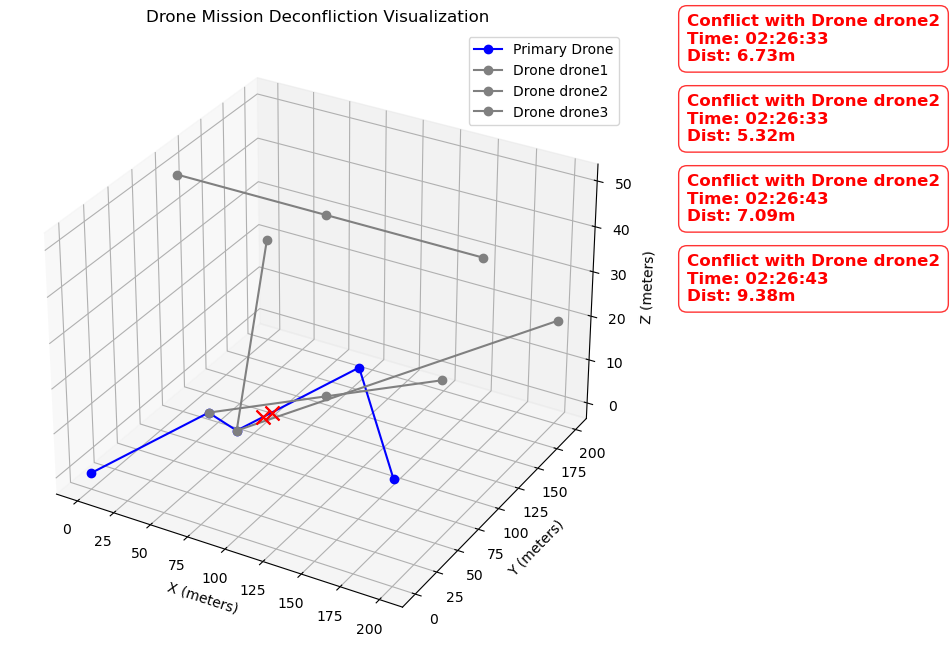

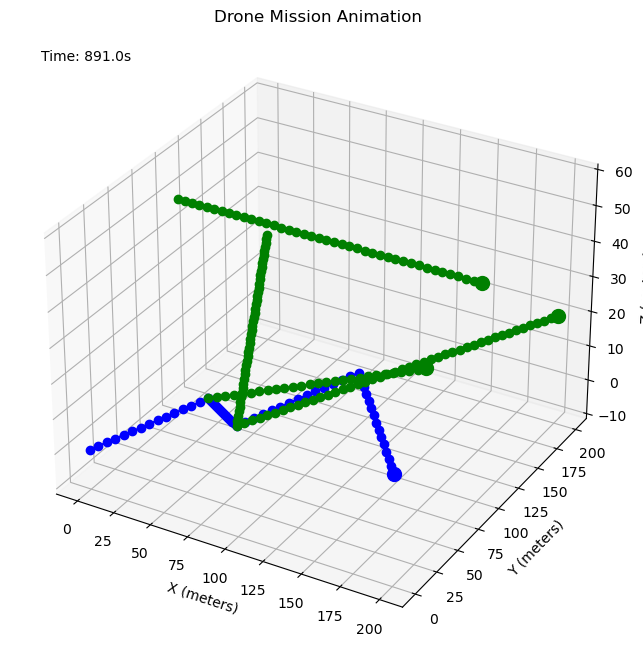

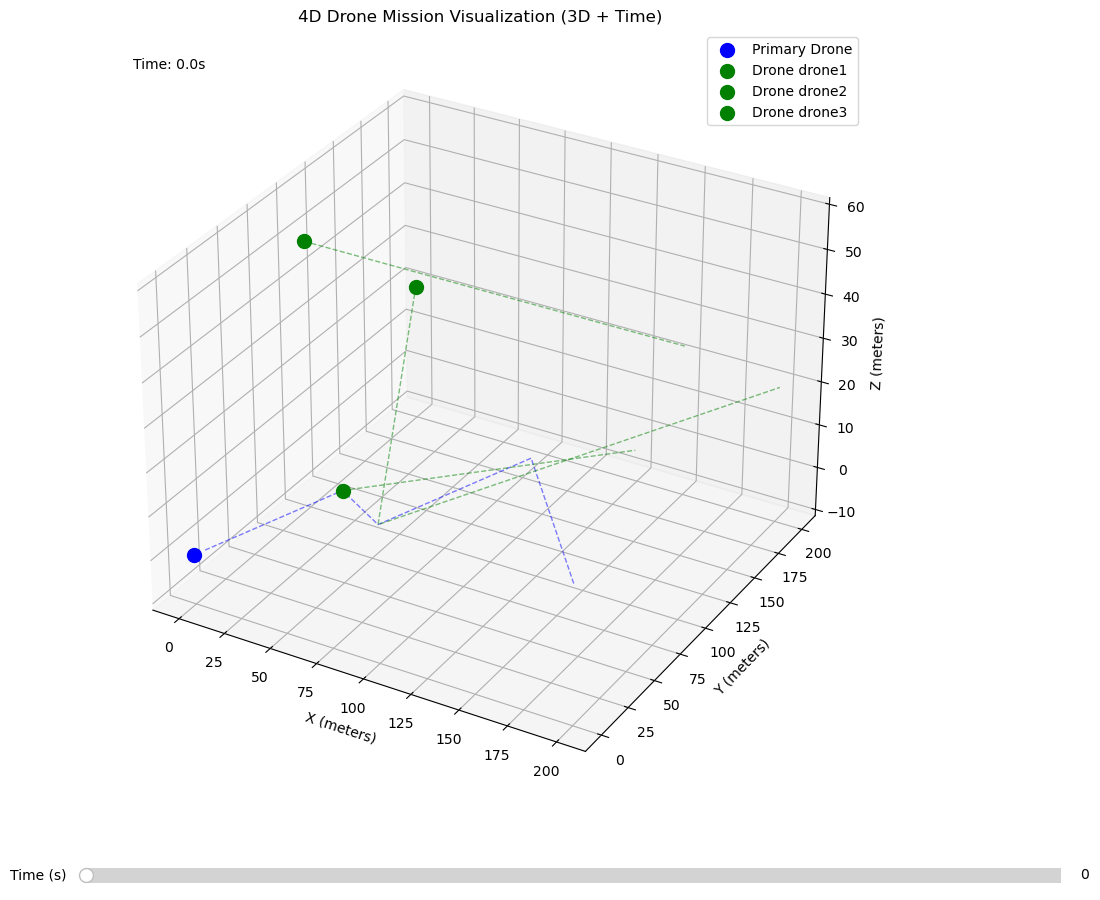

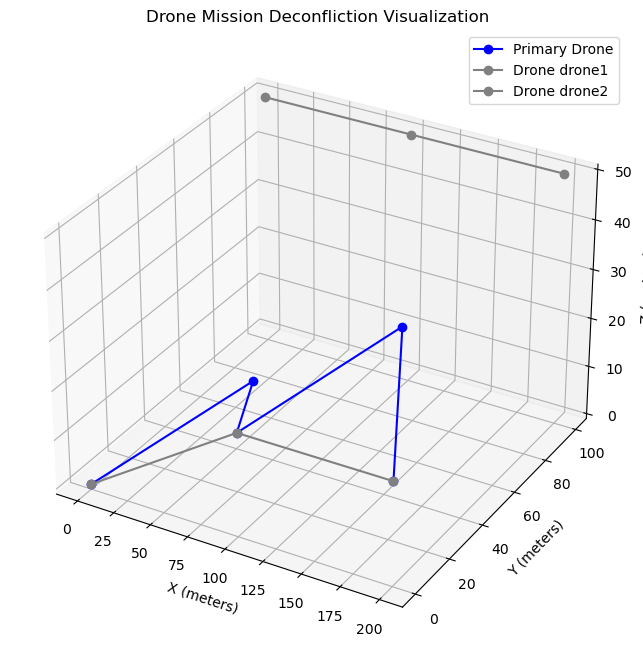

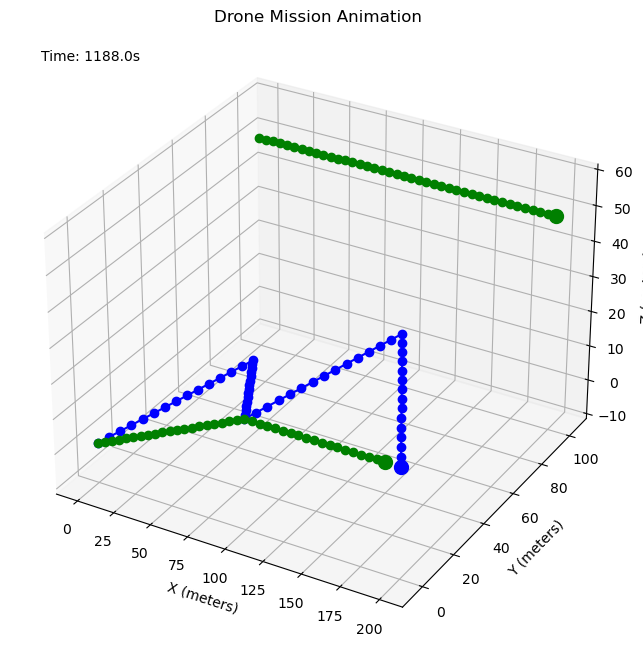

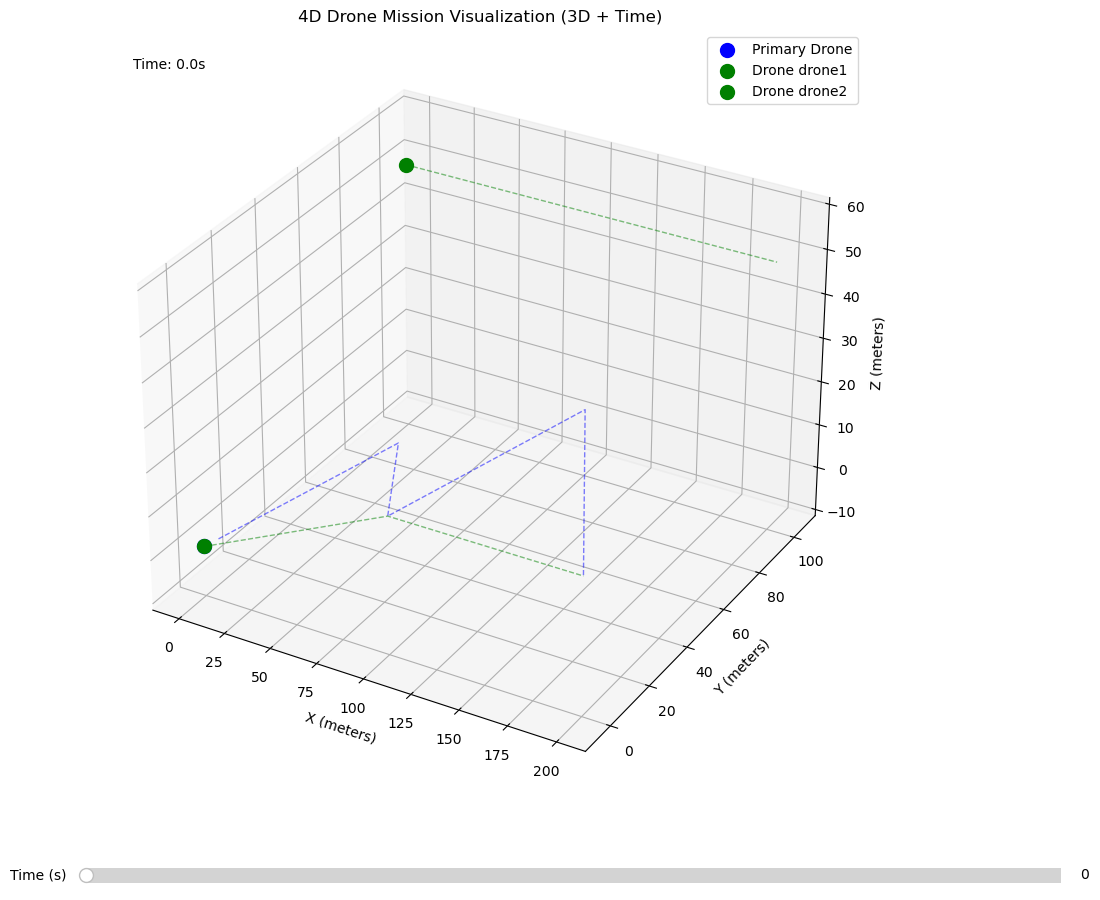

In [5]:
def create_example_scenario():
    """Create an example scenario with primary mission and other flights"""
    # Current time as reference
    now = datetime.now()
    
    # Create primary mission
    primary_waypoints = [
        Waypoint(0, 0, 0),
        Waypoint(50, 50, 10),
        Waypoint(100, 0, 20),
        Waypoint(150, 50, 30),
        Waypoint(200, 0, 20)
    ]
    
    primary_mission = DroneFlightPlan(
        drone_id="primary",
        waypoints=primary_waypoints,
        start_time=now,
        end_time=now + timedelta(minutes=10)
    )
    
    # Create other flights
    other_flights = []
    
    # Flight 1 - No conflict
    flight1_waypoints = [
        Waypoint(0, 100, 50),
        Waypoint(100, 100, 50),
        Waypoint(200, 100, 50)
    ]
    
    flight1 = DroneFlightPlan(
        drone_id="drone1",
        waypoints=flight1_waypoints,
        start_time=now + timedelta(minutes=2),
        end_time=now + timedelta(minutes=8)
    )
    
    other_flights.append(flight1)
    
    # Flight 2 - Spatial conflict
    flight2_waypoints = [
        Waypoint(0, 200, 20),
        Waypoint(100, 0, 20),  # This will cause a conflict
        Waypoint(200, 200, 20)
    ]
    
    flight2 = DroneFlightPlan(
        drone_id="drone2",
        waypoints=flight2_waypoints,
        start_time=now + timedelta(minutes=4),
        end_time=now + timedelta(minutes=7)
    )
    
    other_flights.append(flight2)
    
    # Flight 3 - Temporal separation (no conflict)
    flight3_waypoints = [
        Waypoint(50, 50, 10),
        Waypoint(100, 100, 10),
        Waypoint(150, 150, 10)
    ]
    
    flight3 = DroneFlightPlan(
        drone_id="drone3",
        waypoints=flight3_waypoints,
        start_time=now + timedelta(minutes=12),  # After primary mission
        end_time=now + timedelta(minutes=15)
    )
    
    other_flights.append(flight3)
    
    return primary_mission, other_flights

def create_conflict_free_scenario():
    """Create a scenario with no conflicts"""
    # Current time as reference
    now = datetime.now()
    
    # Create primary mission
    primary_waypoints = [
        Waypoint(0, 0, 0),
        Waypoint(50, 50, 10),
        Waypoint(100, 0, 20),
        Waypoint(150, 50, 30),
        Waypoint(200, 0, 20)
    ]
    
    primary_mission = DroneFlightPlan(
        drone_id="primary",
        waypoints=primary_waypoints,
        start_time=now,
        end_time=now + timedelta(minutes=10)
    )
    
    # Create other flights
    other_flights = []
    
    # Flight 1 - No conflict (spatial separation)
    flight1_waypoints = [
        Waypoint(0, 100, 50),
        Waypoint(100, 100, 50),
        Waypoint(200, 100, 50)
    ]
    
    flight1 = DroneFlightPlan(
        drone_id="drone1",
        waypoints=flight1_waypoints,
        start_time=now + timedelta(minutes=2),
        end_time=now + timedelta(minutes=8)
    )
    
    other_flights.append(flight1)
    
    # Flight 2 - No conflict (temporal separation)
    flight2_waypoints = [
        Waypoint(0, 0, 0),
        Waypoint(100, 0, 20),
        Waypoint(200, 0, 20)
    ]
    
    flight2 = DroneFlightPlan(
        drone_id="drone2",
        waypoints=flight2_waypoints,
        start_time=now + timedelta(minutes=15),  # After primary mission
        end_time=now + timedelta(minutes=20)
    )
    
    other_flights.append(flight2)
    
    return primary_mission, other_flights

def run_example():
    """Run the example scenarios and visualize the results"""
    # Scenario 1: With conflicts
    print("Running scenario with conflicts...")
    primary_mission, other_flights = create_example_scenario()
    
    # Check for conflicts
    result = check_mission_safety(primary_mission, other_flights)
    
    print(f"Mission status: {result.status}")
    if result.conflicts:
        print(f"Found {len(result.conflicts)} conflicts:")
        for conflict in result.conflicts:
            print(f"  - Conflict with Drone {conflict.drone_id} at time {conflict.time}")
            print(f"    Location: ({conflict.location.x}, {conflict.location.y}, {conflict.location.z})")
            print(f"    Distance: {conflict.distance:.2f} meters")
    
    # Visualize the scenario
    visualizer = DeconflictionVisualizer(is_3d=True)
    
    # Static visualization
    fig = visualizer.visualize_mission(primary_mission, other_flights, result.conflicts)
    plt.savefig('conflict_scenario_static.png')
    
    # Animation
    anim = visualizer.create_animation(primary_mission, other_flights, result.conflicts)
    anim.save('conflict_scenario_animation.mp4', writer='ffmpeg', fps=10)
    
    # 4D Visualization (Extra Credit)
    fig_4d, slider = visualizer.create_4d_visualization(primary_mission, other_flights, result.conflicts)
    plt.savefig('conflict_scenario_4d.png')
    
    # Scenario 2: No conflicts
    print("\nRunning conflict-free scenario...")
    primary_mission, other_flights = create_conflict_free_scenario()
    
    # Check for conflicts
    result = check_mission_safety(primary_mission, other_flights)
    
    print(f"Mission status: {result.status}")
    
    # Visualize the scenario
    visualizer = DeconflictionVisualizer(is_3d=True)
    
    # Static visualization
    fig = visualizer.visualize_mission(primary_mission, other_flights, result.conflicts)
    plt.savefig('conflict_free_scenario_static.png')
    
    # Animation
    anim = visualizer.create_animation(primary_mission, other_flights, result.conflicts)
    anim.save('conflict_free_scenario_animation.mp4', writer='ffmpeg', fps=10)
    
    # 4D Visualization
    fig_4d, slider = visualizer.create_4d_visualization(primary_mission, other_flights, result.conflicts)
    plt.savefig('conflict_free_scenario_4d.png')
    
    plt.show()

if __name__ == "__main__":
    run_example()
